In [ ]:
!pip install prophet

In [190]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker.amazon.common as smac
import numpy as np
import os
import time
from prophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import plot
from IPython.display import clear_output

In [191]:
region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
holidays_key = 'holidays_events.csv'
oil_key = 'oil.csv'

holiday = 's3://{}/{}/{}'.format(bucket, prefix, holidays_key)
oil = 's3://{}/{}/{}'.format(bucket, prefix, oil_key)

holidays = pd.read_csv(holiday)
oils = pd.read_csv(oil)


holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
6,2012-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
7,2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
9,2012-06-25,Holiday,Local,Machala,Fundacion de Machala,False


In [192]:
df = pd.concat([oils, holidays])

df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df['month'] = pd.DatetimeIndex(df.index).month
df['year'] = pd.DatetimeIndex(df.index).year
df['day'] = pd.DatetimeIndex(df.index).day

df = df.sort_index()
df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


In [193]:
oil_nans = df[df['dcoilwtico'].isna()]
oil_nans

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
2012-05-12,NaN,Holiday,Local,Puyo,Cantonizacion del Puyo,False,5,2012,12
2012-06-23,NaN,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False,6,2012,23
2012-06-25,NaN,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,6,2012,25
2012-06-25,NaN,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False,6,2012,25


# EDA

In [194]:
corr_matrix = df.copy()
locale = pd.get_dummies(corr_matrix['locale'])
types = pd.get_dummies(corr_matrix['type'])
locale_name = pd.get_dummies(corr_matrix['locale_name'])
transfer = pd.get_dummies(corr_matrix['transferred'], drop_first=True)

corr_matrix = pd.concat([corr_matrix, locale], axis=1)
corr_matrix = pd.concat([corr_matrix, types], axis=1)
corr_matrix = pd.concat([corr_matrix, locale_name], axis=1)
corr_matrix = pd.concat([corr_matrix, transfer], axis=1)

corr_matrix = corr_matrix.drop(['locale', 'type', 'locale_name', 'transferred', 'description'], axis=1)
corr = corr_matrix.corr()
corr

,dcoilwtico,month,year,day,Local,National,Regional,Additional,Bridge,Event,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
dcoilwtico,1.000000,0.003173,-0.833855,-0.007173,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.003173,1.000000,-0.138870,0.022682,0.126706,0.097119,0.052045,0.227619,0.050019,-0.045022,...,-0.064560,-0.028387,0.062045,0.144898,-0.014595,0.098218,0.080132,0.007786,0.080132,0.021710
year,-0.833855,-0.138870,1.000000,0.005138,-0.053876,0.006309,-0.028601,-0.030651,-0.040899,0.064924,...,-0.014218,-0.014218,-0.014218,-0.008573,-0.020146,-0.014218,-0.014218,-0.014218,-0.014218,0.057277
day,-0.007173,0.022682,0.005138,1.000000,-0.033857,-0.000787,-0.080513,0.105935,0.012145,0.007151,...,-0.094052,-0.024338,-0.059195,-0.100778,0.024784,0.045377,-0.059195,-0.087081,-0.066167,-0.015552
Local,NaN,0.126706,-0.053876,-0.033857,1.000000,-0.115753,-0.040848,0.073588,-0.018531,-0.063053,...,0.189167,0.189167,0.189167,0.279072,0.268038,0.189167,-0.020306,0.189167,-0.020306,0.070164
National,NaN,0.097119,0.006309,-0.000787,-0.115753,1.000000,-0.044048,0.393070,0.160089,0.544722,...,-0.021897,-0.021897,-0.021897,-0.032304,-0.031026,-0.021897,-0.021897,-0.021897,-0.021897,0.155369
Regional,NaN,0.052045,-0.028601,-0.080513,-0.040848,-0.044048,1.000000,-0.022860,-0.007052,-0.023994,...,-0.007727,-0.007727,-0.007727,-0.011400,-0.010949,-0.007727,0.497111,-0.007727,0.497111,-0.010949
Additional,NaN,0.227619,-0.030651,0.105935,0.073588,0.393070,-0.022860,1.000000,-0.010370,-0.035287,...,-0.011364,-0.011364,-0.011364,0.221129,-0.016102,-0.011364,-0.011364,-0.011364,-0.011364,-0.016102
Bridge,NaN,0.050019,-0.040899,0.012145,-0.018531,0.160089,-0.007052,-0.010370,1.000000,-0.010885,...,-0.003505,-0.003505,-0.003505,-0.005171,-0.004967,-0.003505,-0.003505,-0.003505,-0.003505,-0.004967
Event,NaN,-0.045022,0.064924,0.007151,-0.063053,0.544722,-0.023994,-0.035287,-0.010885,1.000000,...,-0.011928,-0.011928,-0.011928,-0.017596,-0.016901,-0.011928,-0.011928,-0.011928,-0.011928,-0.016901


Text(0.5, 1.0, 'Correlation heatmap')

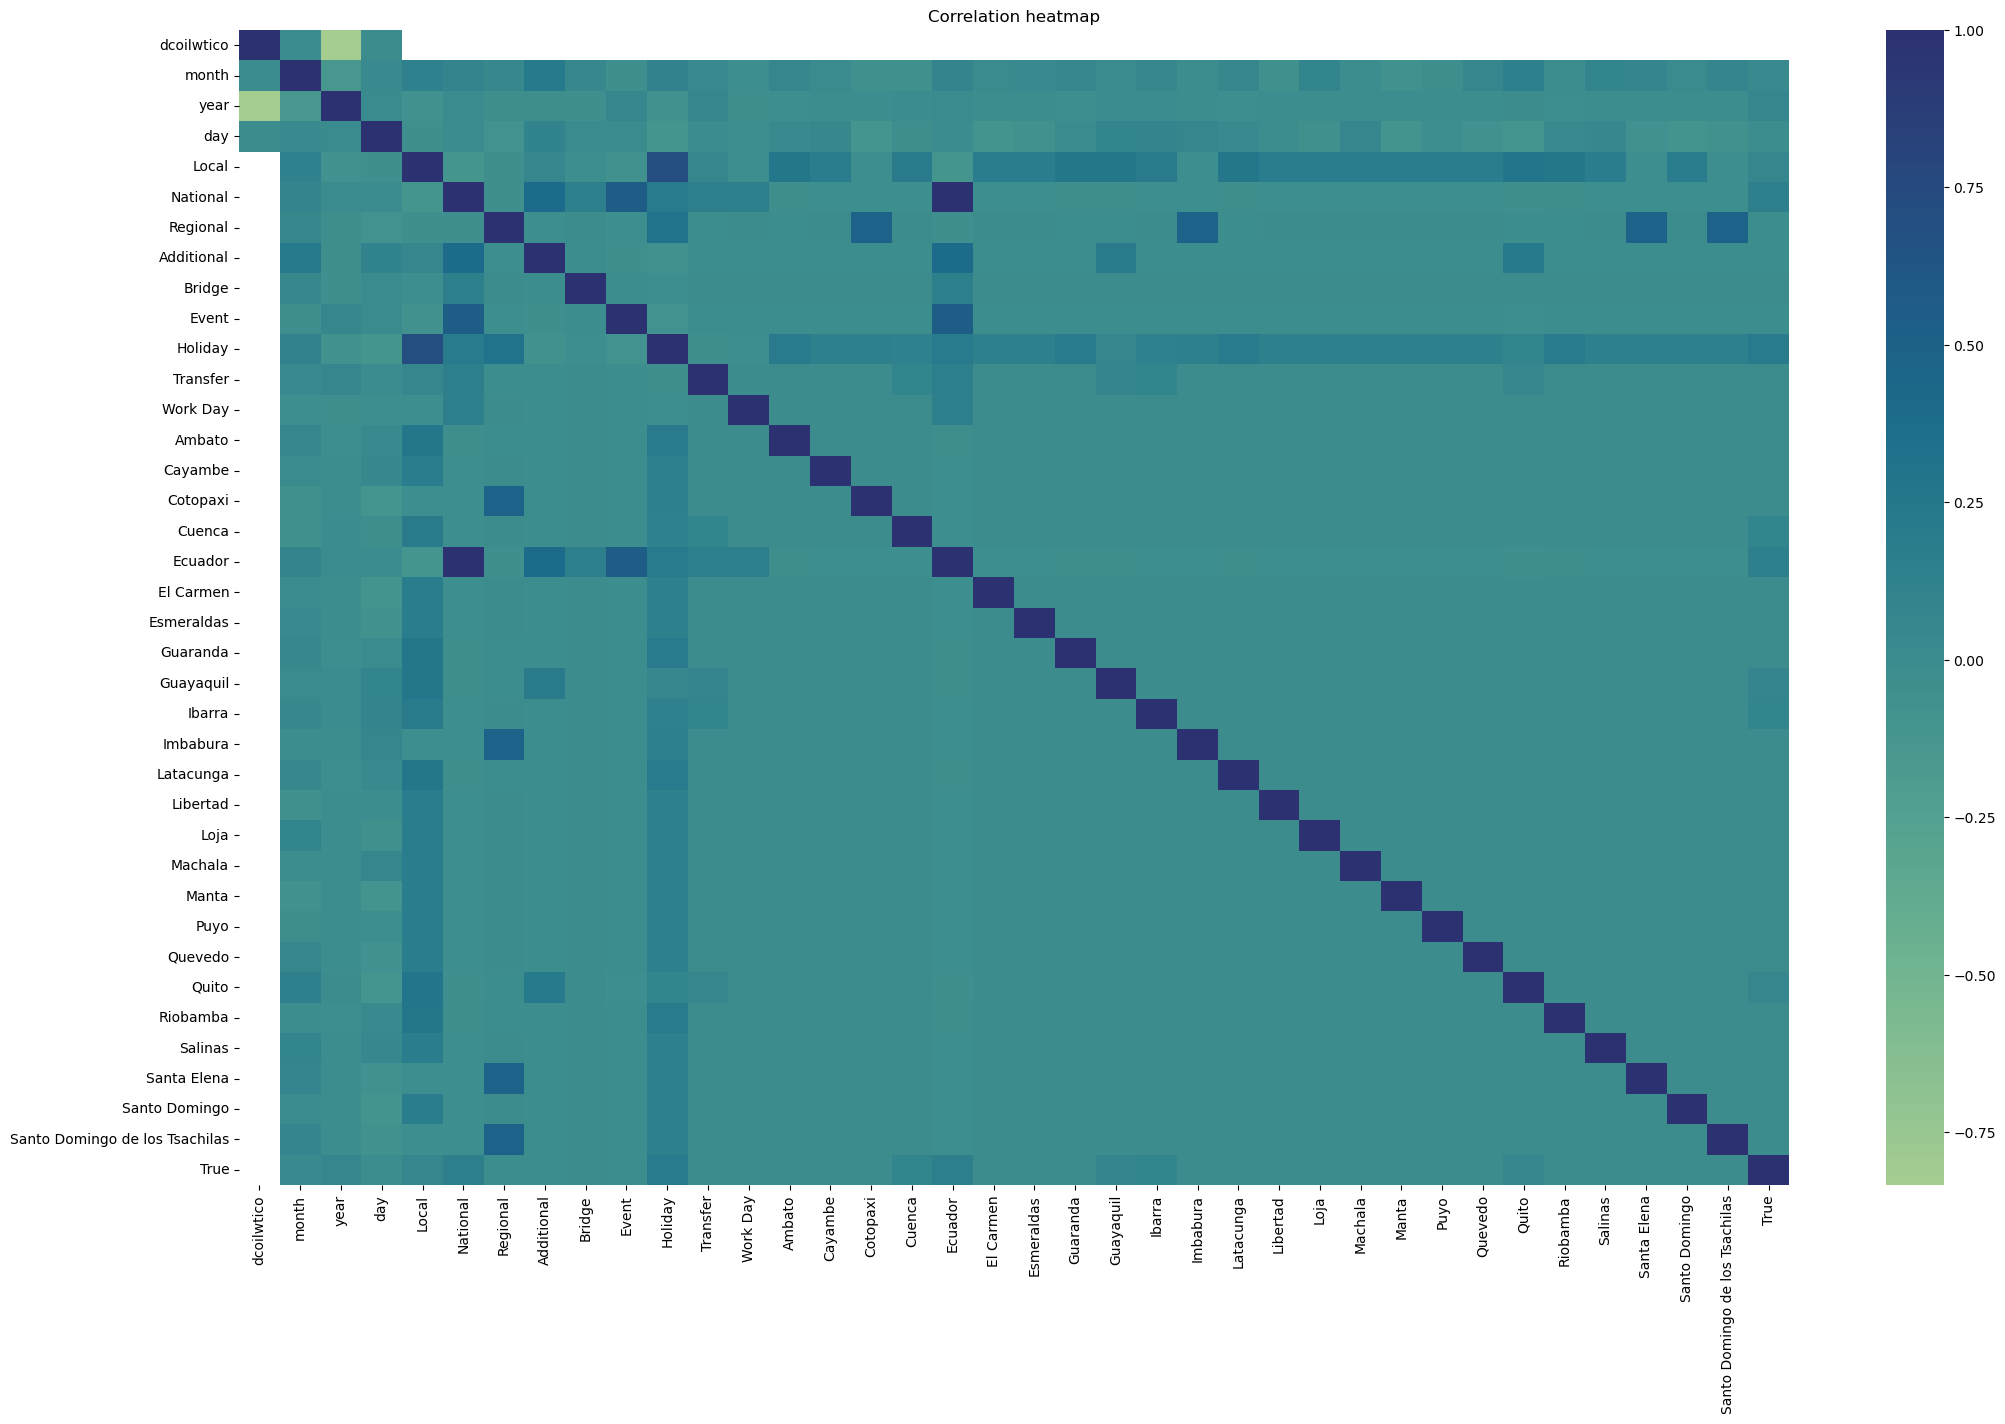

In [195]:
plt.figure(figsize=(25,15))
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


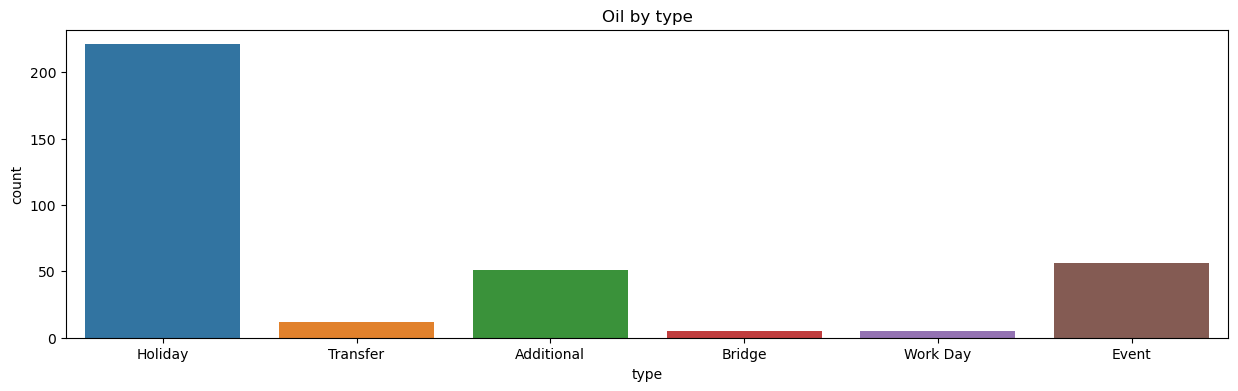

In [196]:
plt.figure(figsize=(15,4))
sns.countplot(data=df, x='type')
plt.title('Oil by type')
df

Text(0.5, 1.0, 'Oil by day')

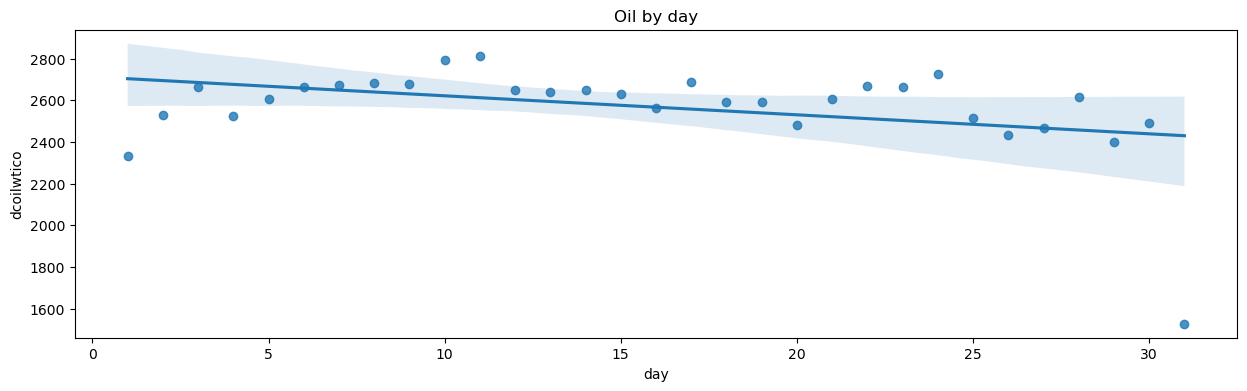

In [197]:
oil_by_day = df.groupby('day')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_day.index, y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by day')

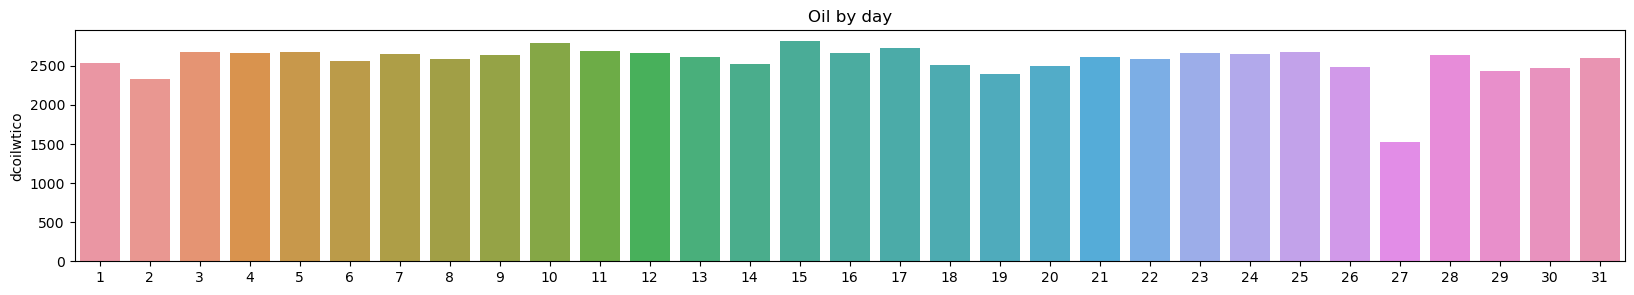

In [198]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['day'].unique(), y=oil_by_day)
plt.title('Oil by day')

Text(0.5, 1.0, 'Oil by month')

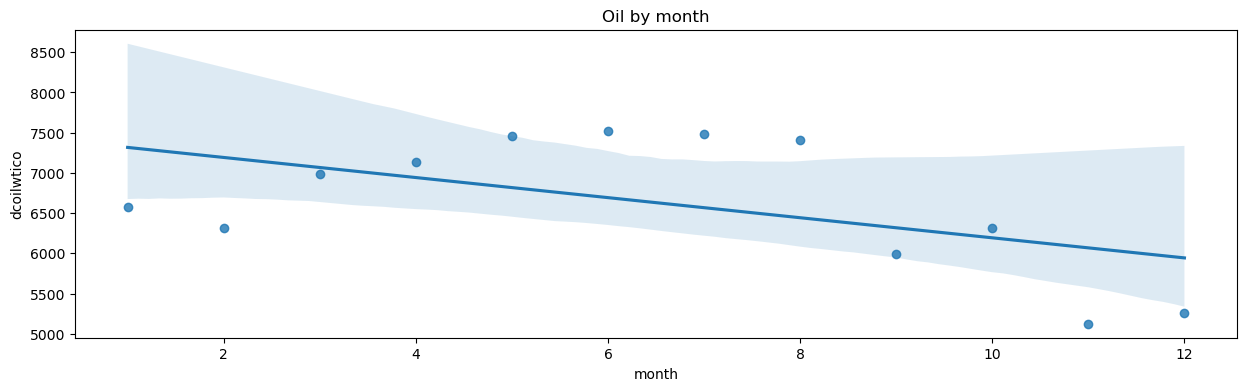

In [199]:
oil_by_month = df.groupby('month')['dcoilwtico'].sum()
plt.figure(figsize=(15,4))
sns.regplot(x=oil_by_month.index, y=oil_by_month)
plt.title('Oil by month')

Text(0.5, 1.0, 'Oil by month')

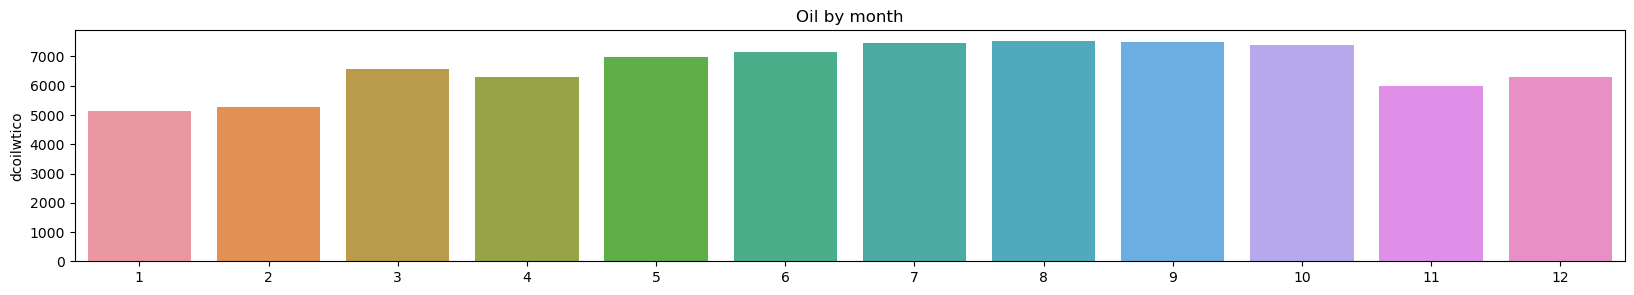

In [200]:
plt.figure(figsize=(20,3))
sns.barplot(x=df['month'].unique(), y=oil_by_month)
plt.title('Oil by month')

Text(0.5, 1.0, 'Oil in 2013')

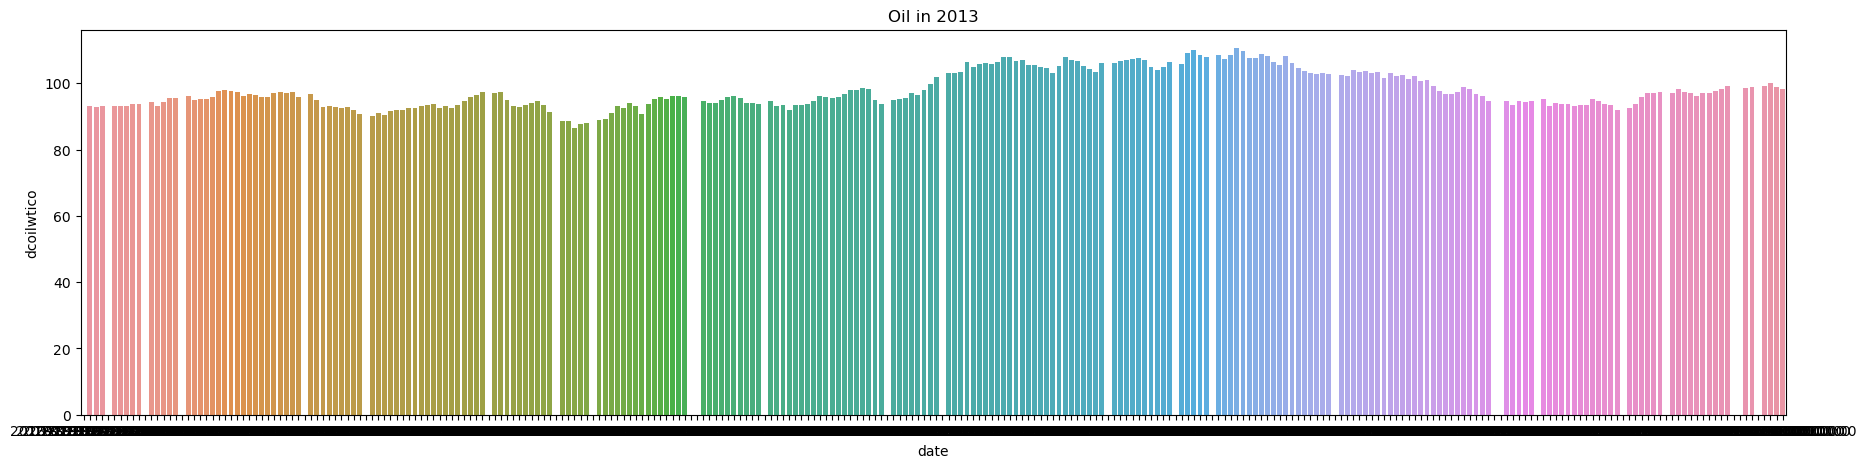

In [201]:
plt.figure(figsize=(22,5))

year = df[df['year'] == 2013]

oil_per_2013_year = year.groupby(['date'])['dcoilwtico'].sum()

sns.barplot(x=oil_per_2013_year.index.unique(), y=oil_per_2013_year)
plt.title('Oil in 2013')

Text(0.5, 1.0, 'Oil in 2017')

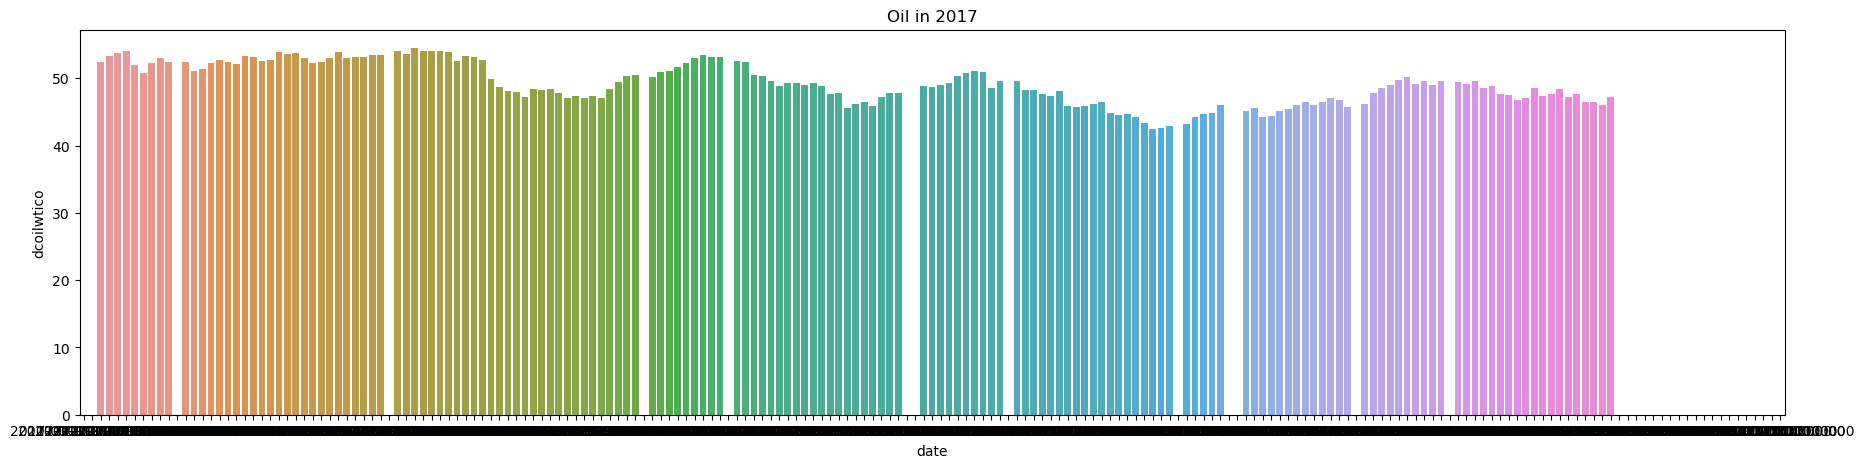

In [202]:
plt.figure(figsize=(22,5))

year = df[df['year'] == 2017]

oil_per_2017_year = year.groupby(['date'])['dcoilwtico'].sum()

sns.barplot(x=oil_per_2017_year.index.unique(), y=oil_per_2017_year)
plt.title('Oil in 2017')

Text(0.5, 1.0, 'Oil by year')

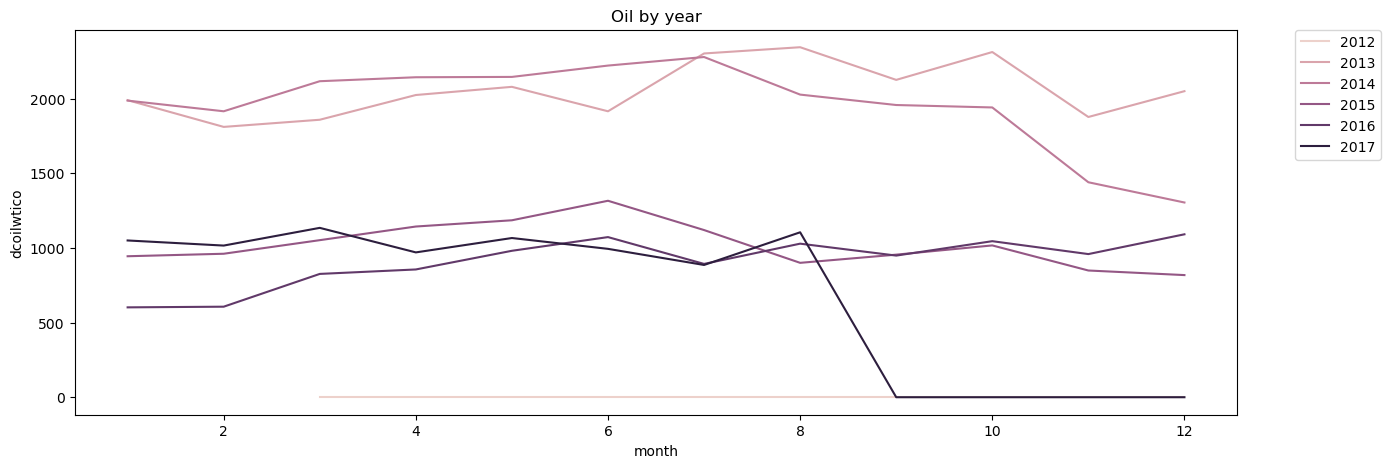

In [203]:
oil_per_year = df.groupby(['year','month'])['dcoilwtico'].sum()

oil_per_year = pd.DataFrame(oil_per_year)
oil_per_year = oil_per_year.reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_year, x=oil_per_year['month'], y=oil_per_year['dcoilwtico'],hue=oil_per_year['year'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by year')

Text(0.5, 1.0, 'Oil by day')

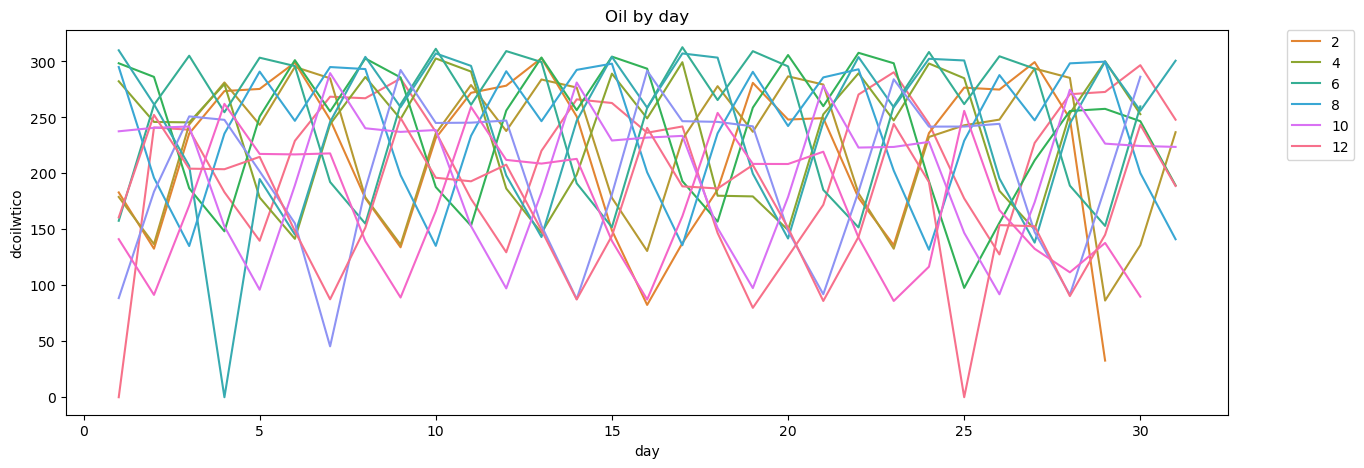

In [204]:
oil_per_day = df.groupby(['month','day'])['dcoilwtico'].sum()

oil_per_day = pd.DataFrame(oil_per_day)
oil_per_day = oil_per_day.reset_index()


plt.figure(figsize=(15,5))
sns.lineplot(data=oil_per_day, x=oil_per_day['day'], y=oil_per_day['dcoilwtico'],hue=oil_per_day['month'], palette='husl')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Oil by day')

In [205]:
types_mode = df['type'].value_counts().idxmax()
locale_mode = df['locale'].value_counts().idxmax()
locale_name_mode = df['locale_name'].value_counts().idxmax()
description_mode = df['description'].value_counts().idxmax()
transferred_mode = df['transferred'].value_counts().idxmax()

df.loc[df['type'].isna(), 'type'] = types_mode
df.loc[df['locale'].isna(), 'locale'] = locale_mode
df.loc[df['locale_name'].isna(), 'locale_name'] = locale_name_mode
df.loc[df['description'].isna(), 'description'] = description_mode
df.loc[df['transferred'].isna(), 'transferred'] = transferred_mode

df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,NaN,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,NaN,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,NaN,Additional,National,Ecuador,Navidad-1,False,12,2017,24


Text(0.5, 1.0, 'Type by month')

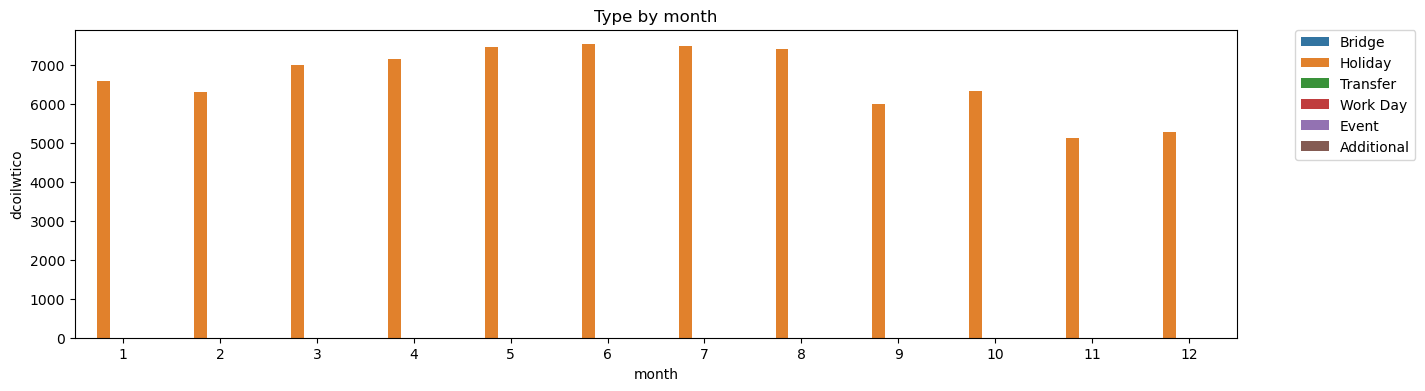

In [206]:
type_by_month_count = df.groupby(['month', 'type'])['dcoilwtico'].sum()
type_by_month_count = type_by_month_count.reset_index()

plt.figure(figsize=(15,4))
sns.barplot(data=type_by_month_count, x=type_by_month_count['month'], y=type_by_month_count['dcoilwtico'], hue=type_by_month_count['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Type by month')

# Feature engineering/Cleaning

In [207]:
oil_nans = df[df['dcoilwtico'].isna()]

oil_nans_by_month = df[df['dcoilwtico'].isna()]['month']
months_with_oil_nan = oil_nans_by_month.unique()

average_oil_by_month = []

for i in months_with_oil_nan:
    month_vals = df[df['month'] == i]
    total_oil = month_vals['dcoilwtico'].sum()
    average = round((total_oil/len(month_vals)), 2)
    average_oil_by_month.append((i, average))

for i in range(len(months_with_oil_nan)):
    df = df.copy()
    df.loc[(df['month'] == average_oil_by_month[i][0]) & (df['dcoilwtico'].isna()), 'dcoilwtico'] = average_oil_by_month[i][1]

In [850]:
#df['dcoilwtico'] = df['dcoilwtico'].interpolate(method ='bfill')
df = df.interpolate(method ='linear')
df

,dcoilwtico,type,locale,locale_name,description,transferred,month,year,day
date,,,,,,,,,
2012-03-02,NaN,Holiday,Local,Manta,Fundacion de Manta,False,3,2012,2
2012-04-01,NaN,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,4,2012,1
2012-04-12,NaN,Holiday,Local,Cuenca,Fundacion de Cuenca,False,4,2012,12
2012-04-14,NaN,Holiday,Local,Libertad,Cantonizacion de Libertad,False,4,2012,14
2012-04-21,NaN,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,4,2012,21
...,...,...,...,...,...,...,...,...,...
2017-12-22,47.26,Additional,National,Ecuador,Navidad-3,False,12,2017,22
2017-12-23,47.26,Additional,National,Ecuador,Navidad-2,False,12,2017,23
2017-12-24,47.26,Additional,National,Ecuador,Navidad-1,False,12,2017,24


In [208]:
types = pd.get_dummies(df['type'])
locale = pd.get_dummies(df['locale'])
locale_name = pd.get_dummies(df['locale_name'])
transferred = pd.get_dummies(df['transferred'], drop_first=True)

df = pd.concat([df, types], axis=1)
df = pd.concat([df, locale], axis=1)
df = pd.concat([df, locale_name], axis=1)
df = pd.concat([df, transferred], axis=1)

df = df.drop(['type', 'locale', 'locale_name', 'description', 'transferred','day'], axis=1)

df = df.dropna()
df

,dcoilwtico,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,Local,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
date,,,,,,,,,,,,,,,,,,,,,
2012-03-02,58.73,3,2012,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2012-04-01,47.27,4,2012,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2012-04-12,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-04-14,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2012-04-21,47.27,4,2012,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-24,32.70,12,2017,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [209]:
df[True] = df[True].astype('uint8')
df.columns = df.columns.map(str)

In [210]:
from sklearn.preprocessing import MinMaxScaler

train = df.loc[df.index < '2016-12-29']
test = df.loc[(df.index >= '2016-12-29')].drop('dcoilwtico', axis=1)
test_y = df.loc[(df.index >= '2016-12-29')]['dcoilwtico']

train = train.drop(train[train['year'] == 2012].index)
#train = train.drop(train[train['year'] == 2017].index)

train = pd.DataFrame(train)
train = train.reset_index()
test = test.reset_index()
train = train.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})
test_x = test.rename(columns={'date' : 'ds', 'dcoilwtico' : 'y'})
#train = train[['ds','y']]
#test_x = test_x[['ds']]

train.to_csv("train.csv", header=False, index=False)
test.to_csv("test.csv", header=False, index=False)

bucket = sagemaker.Session().default_bucket()

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
bucket
train

,ds,y,month,year,Additional,Bridge,Event,Holiday,Transfer,Work Day,...,Manta,Puyo,Quevedo,Quito,Riobamba,Salinas,Santa Elena,Santo Domingo,Santo Domingo de los Tsachilas,True
0,2013-01-01,54.32,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,54.32,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-02,93.14,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-03,92.97,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-04,93.12,1,2013,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,2016-12-25,32.70,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1293,2016-12-26,32.70,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1294,2016-12-26,32.70,12,2016,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1295,2016-12-27,52.82,12,2016,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
holidays = pd.DataFrame([
    {'holiday': 'shock_1', 'ds': '2017-08-01', 'lower_window': 0, 'ds_upper': '2017-12-30'},
])
for t_col in ['ds', 'ds_upper']:
    holidays[t_col] = pd.to_datetime(holidays[t_col])
holidays['upper_window'] = (holidays['ds_upper'] - holidays['ds']).dt.days
holidays

,holiday,ds,lower_window,ds_upper,upper_window
0,shock_1,2017-08-01,0,2017-12-30,151


In [147]:
model = Prophet()

columns = train.columns.drop(['y', 'ds'])

for i in columns:
    model.add_regressor(str(i))

model = model.fit(train)

forecast = model.predict(test_x)
forecast

19:57:07 - cmdstanpy - INFO - Chain [1] start processing
19:57:07 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Additional,Additional_lower,Additional_upper,Ambato,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-12-29,19.899293,23.449251,54.275900,19.899293,19.899293,0.000000,0.000000,0.000000,0.000000,...,-0.367947,-0.367947,-0.367947,-10.749057,-10.749057,-10.749057,0.0,0.0,0.0,38.936680
1,2016-12-30,19.914787,23.959349,53.040852,19.914787,19.914787,0.000000,0.000000,0.000000,0.000000,...,-0.367947,-0.367947,-0.367947,-11.039334,-11.039334,-11.039334,0.0,0.0,0.0,38.617539
2,2016-12-31,19.930281,-1.859524,28.677701,19.930281,19.930281,-7.692161,-7.692161,-7.692161,0.000000,...,-0.367947,-0.367947,-0.367947,-11.284282,-11.284282,-11.284282,0.0,0.0,0.0,13.703142
3,2017-01-01,19.945774,5.655163,36.844647,19.945774,19.945774,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.482246,-11.482246,-11.482246,0.0,0.0,0.0,20.253120
4,2017-01-02,19.961268,17.731114,48.798812,19.961268,19.961268,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.632373,-11.632373,-11.632373,0.0,0.0,0.0,32.011874
5,2017-01-02,19.961268,23.980605,55.132615,19.961268,19.961268,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.632373,-11.632373,-11.632373,0.0,0.0,0.0,40.000939
6,2017-01-03,19.976762,26.380701,57.750100,19.976762,19.976783,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.734614,-11.734614,-11.734614,0.0,0.0,0.0,41.038294
7,2017-01-04,19.992256,25.386799,55.934087,19.991460,19.995547,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.789712,-11.789712,-11.789712,0.0,0.0,0.0,40.658918
8,2017-01-05,20.007749,25.030246,56.278657,20.004249,20.014339,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.799163,-11.799163,-11.799163,0.0,0.0,0.0,41.059239
9,2017-01-06,20.023243,25.307144,56.537440,20.016406,20.035374,0.000000,0.000000,0.000000,0.000000,...,-0.618459,-0.618459,-0.618459,-11.765174,-11.765174,-11.765174,0.0,0.0,0.0,41.064365


In [148]:
baseline = cross_validation(model, initial='1297 days', period='60 days', horizon = '10 days', parallel="processes")
df_p = performance_metrics(baseline, rolling_window=1)
df_p

19:57:08 - cmdstanpy - INFO - Chain [1] start processing
19:57:08 - cmdstanpy - INFO - Chain [1] start processing
19:57:08 - cmdstanpy - INFO - Chain [1] done processing
19:57:09 - cmdstanpy - INFO - Chain [1] done processing
19:57:09 - cmdstanpy - INFO - Chain [1] start processing
19:57:09 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,10 days,158.026165,12.570846,10.682381,0.251478,0.214975,0.308792,0.766667


MAE is  9.612779866146976
MAPE is  0.2012203933255238


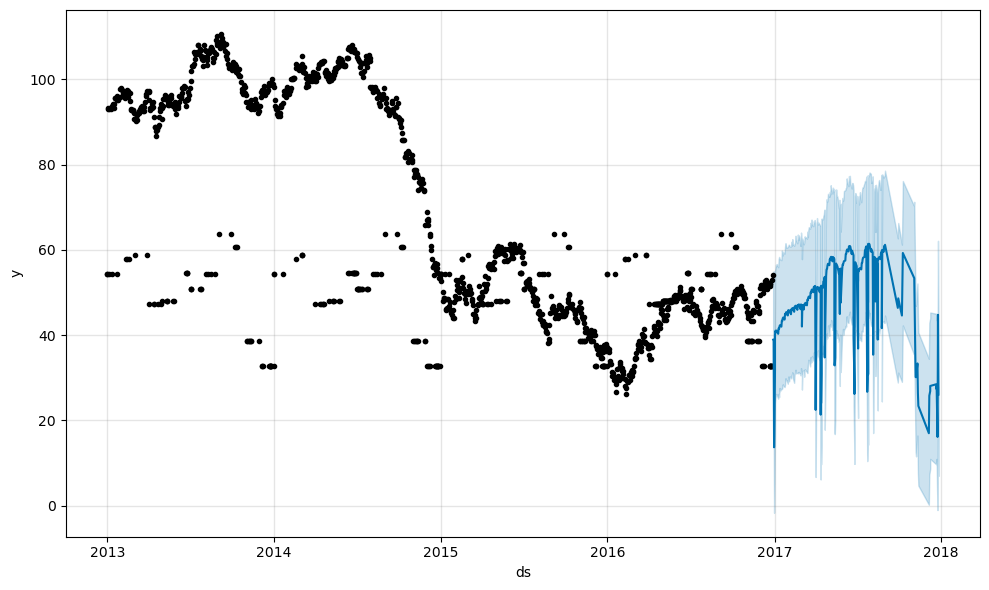

In [149]:
forecast_before = model.predict(test_x)

test_y = test_y.reset_index()

forecast_before['true'] = test_y['dcoilwtico']

mae = mean_absolute_error(forecast_before['true'], forecast_before['yhat'])
mape = mean_absolute_percentage_error(forecast_before['true'], forecast_before['yhat'])

print('MAE is ', mae)
print('MAPE is ', mape)

forecast_before[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']]

plot_measure = model.plot(forecast_before)


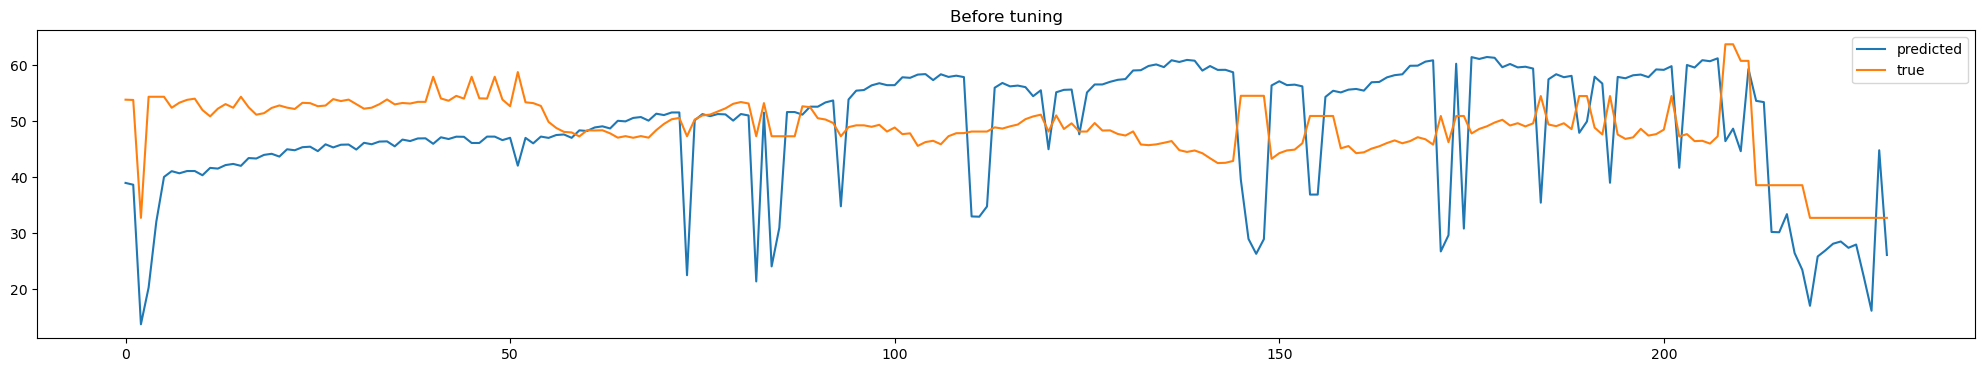

In [150]:
plt.figure(figsize=(25,4))
plt.plot(forecast_before['yhat'], label='predicted')
plt.plot(forecast_before['true'], label='true')
plt.legend()
plt.title('Before tuning')
plt.show()

In [151]:
param_grid = {  
    'changepoint_prior_scale': [0.01, 0.05,0.1],
    'seasonality_mode' : ['multiplicative'],
    'seasonality_prior_scale' : [25,35,45],
    'n_changepoints' : [20,30,35],
    'holidays_prior_scale' : [20,30,35]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mape = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    for i in columns:
        m.add_regressor(str(i))
    print(params)
    m.fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='1297 days', period='60 days', horizon = '10 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])
    print(df_p['mape'].values[0])
    #clear_output(wait=True)


# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
print(tuning_results)

19:57:10 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 20}


19:57:11 - cmdstanpy - INFO - Chain [1] done processing
19:57:11 - cmdstanpy - INFO - Chain [1] start processing
19:57:11 - cmdstanpy - INFO - Chain [1] start processing
19:57:12 - cmdstanpy - INFO - Chain [1] done processing
19:57:12 - cmdstanpy - INFO - Chain [1] done processing
19:57:12 - cmdstanpy - INFO - Chain [1] start processing
19:57:13 - cmdstanpy - INFO - Chain [1] done processing
19:57:13 - cmdstanpy - INFO - Chain [1] start processing


0.10646405399593707
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 30}


19:57:13 - cmdstanpy - INFO - Chain [1] done processing
19:57:14 - cmdstanpy - INFO - Chain [1] start processing
19:57:14 - cmdstanpy - INFO - Chain [1] start processing
19:57:14 - cmdstanpy - INFO - Chain [1] done processing
19:57:15 - cmdstanpy - INFO - Chain [1] done processing
19:57:15 - cmdstanpy - INFO - Chain [1] start processing
19:57:15 - cmdstanpy - INFO - Chain [1] done processing
19:57:16 - cmdstanpy - INFO - Chain [1] start processing


0.10539822027976964
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 35}


19:57:16 - cmdstanpy - INFO - Chain [1] done processing
19:57:16 - cmdstanpy - INFO - Chain [1] start processing
19:57:16 - cmdstanpy - INFO - Chain [1] start processing
19:57:17 - cmdstanpy - INFO - Chain [1] done processing
19:57:17 - cmdstanpy - INFO - Chain [1] done processing
19:57:17 - cmdstanpy - INFO - Chain [1] start processing
19:57:18 - cmdstanpy - INFO - Chain [1] done processing
19:57:18 - cmdstanpy - INFO - Chain [1] start processing


0.09377134020566785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 20}


19:57:19 - cmdstanpy - INFO - Chain [1] done processing
19:57:19 - cmdstanpy - INFO - Chain [1] start processing
19:57:19 - cmdstanpy - INFO - Chain [1] start processing
19:57:20 - cmdstanpy - INFO - Chain [1] done processing
19:57:20 - cmdstanpy - INFO - Chain [1] done processing
19:57:20 - cmdstanpy - INFO - Chain [1] start processing
19:57:21 - cmdstanpy - INFO - Chain [1] done processing
19:57:21 - cmdstanpy - INFO - Chain [1] start processing


0.09985497915606288
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 30}


19:57:21 - cmdstanpy - INFO - Chain [1] done processing
19:57:22 - cmdstanpy - INFO - Chain [1] start processing
19:57:22 - cmdstanpy - INFO - Chain [1] start processing
19:57:23 - cmdstanpy - INFO - Chain [1] done processing
19:57:23 - cmdstanpy - INFO - Chain [1] done processing
19:57:23 - cmdstanpy - INFO - Chain [1] start processing
19:57:24 - cmdstanpy - INFO - Chain [1] done processing
19:57:24 - cmdstanpy - INFO - Chain [1] start processing


0.1022167520600074
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 35}


19:57:25 - cmdstanpy - INFO - Chain [1] done processing
19:57:25 - cmdstanpy - INFO - Chain [1] start processing
19:57:25 - cmdstanpy - INFO - Chain [1] start processing
19:57:26 - cmdstanpy - INFO - Chain [1] done processing
19:57:26 - cmdstanpy - INFO - Chain [1] done processing
19:57:26 - cmdstanpy - INFO - Chain [1] start processing
19:57:27 - cmdstanpy - INFO - Chain [1] done processing
19:57:27 - cmdstanpy - INFO - Chain [1] start processing


0.10170036028279733
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 20}


19:57:28 - cmdstanpy - INFO - Chain [1] done processing
19:57:28 - cmdstanpy - INFO - Chain [1] start processing
19:57:28 - cmdstanpy - INFO - Chain [1] start processing
19:57:29 - cmdstanpy - INFO - Chain [1] done processing
19:57:29 - cmdstanpy - INFO - Chain [1] done processing
19:57:29 - cmdstanpy - INFO - Chain [1] start processing
19:57:30 - cmdstanpy - INFO - Chain [1] done processing
19:57:30 - cmdstanpy - INFO - Chain [1] start processing


0.09806813345185046
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 30}


19:57:30 - cmdstanpy - INFO - Chain [1] done processing
19:57:31 - cmdstanpy - INFO - Chain [1] start processing
19:57:31 - cmdstanpy - INFO - Chain [1] start processing
19:57:31 - cmdstanpy - INFO - Chain [1] done processing
19:57:32 - cmdstanpy - INFO - Chain [1] done processing
19:57:32 - cmdstanpy - INFO - Chain [1] start processing
19:57:33 - cmdstanpy - INFO - Chain [1] done processing
19:57:33 - cmdstanpy - INFO - Chain [1] start processing


0.104525103006366
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 35}


19:57:33 - cmdstanpy - INFO - Chain [1] done processing
19:57:34 - cmdstanpy - INFO - Chain [1] start processing
19:57:34 - cmdstanpy - INFO - Chain [1] start processing
19:57:35 - cmdstanpy - INFO - Chain [1] done processing
19:57:35 - cmdstanpy - INFO - Chain [1] done processing
19:57:35 - cmdstanpy - INFO - Chain [1] start processing
19:57:36 - cmdstanpy - INFO - Chain [1] done processing
19:57:36 - cmdstanpy - INFO - Chain [1] start processing


0.102922504144502
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 20}


19:57:37 - cmdstanpy - INFO - Chain [1] done processing
19:57:37 - cmdstanpy - INFO - Chain [1] start processing
19:57:37 - cmdstanpy - INFO - Chain [1] start processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing
19:57:38 - cmdstanpy - INFO - Chain [1] start processing
19:57:38 - cmdstanpy - INFO - Chain [1] done processing
19:57:39 - cmdstanpy - INFO - Chain [1] start processing


0.10177684482461379
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 30}


19:57:39 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] start processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:40 - cmdstanpy - INFO - Chain [1] done processing
19:57:41 - cmdstanpy - INFO - Chain [1] start processing
19:57:41 - cmdstanpy - INFO - Chain [1] done processing
19:57:41 - cmdstanpy - INFO - Chain [1] start processing


0.09621974632837649
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 35}


19:57:42 - cmdstanpy - INFO - Chain [1] done processing
19:57:42 - cmdstanpy - INFO - Chain [1] start processing
19:57:42 - cmdstanpy - INFO - Chain [1] start processing
19:57:43 - cmdstanpy - INFO - Chain [1] done processing
19:57:43 - cmdstanpy - INFO - Chain [1] done processing
19:57:43 - cmdstanpy - INFO - Chain [1] start processing
19:57:44 - cmdstanpy - INFO - Chain [1] done processing
19:57:44 - cmdstanpy - INFO - Chain [1] start processing


0.09560089198688093
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 20}


19:57:44 - cmdstanpy - INFO - Chain [1] done processing
19:57:45 - cmdstanpy - INFO - Chain [1] start processing
19:57:45 - cmdstanpy - INFO - Chain [1] start processing
19:57:46 - cmdstanpy - INFO - Chain [1] done processing
19:57:46 - cmdstanpy - INFO - Chain [1] done processing
19:57:46 - cmdstanpy - INFO - Chain [1] start processing
19:57:46 - cmdstanpy - INFO - Chain [1] done processing
19:57:47 - cmdstanpy - INFO - Chain [1] start processing


0.09604972680605345
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 30}


19:57:47 - cmdstanpy - INFO - Chain [1] done processing
19:57:47 - cmdstanpy - INFO - Chain [1] start processing
19:57:47 - cmdstanpy - INFO - Chain [1] start processing
19:57:48 - cmdstanpy - INFO - Chain [1] done processing
19:57:48 - cmdstanpy - INFO - Chain [1] done processing
19:57:49 - cmdstanpy - INFO - Chain [1] start processing
19:57:49 - cmdstanpy - INFO - Chain [1] done processing
19:57:50 - cmdstanpy - INFO - Chain [1] start processing


0.1001430174060399
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 35}


19:57:50 - cmdstanpy - INFO - Chain [1] done processing
19:57:51 - cmdstanpy - INFO - Chain [1] start processing
19:57:51 - cmdstanpy - INFO - Chain [1] start processing
19:57:51 - cmdstanpy - INFO - Chain [1] done processing
19:57:52 - cmdstanpy - INFO - Chain [1] done processing
19:57:52 - cmdstanpy - INFO - Chain [1] start processing
19:57:52 - cmdstanpy - INFO - Chain [1] done processing
19:57:53 - cmdstanpy - INFO - Chain [1] start processing


0.1036030507723815
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 20}


19:57:53 - cmdstanpy - INFO - Chain [1] done processing
19:57:53 - cmdstanpy - INFO - Chain [1] start processing
19:57:53 - cmdstanpy - INFO - Chain [1] start processing
19:57:54 - cmdstanpy - INFO - Chain [1] done processing
19:57:54 - cmdstanpy - INFO - Chain [1] done processing
19:57:55 - cmdstanpy - INFO - Chain [1] start processing
19:57:55 - cmdstanpy - INFO - Chain [1] done processing
19:57:55 - cmdstanpy - INFO - Chain [1] start processing


0.10802343488116156
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 30}


19:57:56 - cmdstanpy - INFO - Chain [1] done processing
19:57:56 - cmdstanpy - INFO - Chain [1] start processing
19:57:56 - cmdstanpy - INFO - Chain [1] start processing
19:57:57 - cmdstanpy - INFO - Chain [1] done processing
19:57:57 - cmdstanpy - INFO - Chain [1] done processing
19:57:58 - cmdstanpy - INFO - Chain [1] start processing
19:57:58 - cmdstanpy - INFO - Chain [1] done processing
19:57:58 - cmdstanpy - INFO - Chain [1] start processing


0.10310813682281772
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 35}


19:57:59 - cmdstanpy - INFO - Chain [1] done processing
19:57:59 - cmdstanpy - INFO - Chain [1] start processing
19:57:59 - cmdstanpy - INFO - Chain [1] start processing
19:58:00 - cmdstanpy - INFO - Chain [1] done processing
19:58:00 - cmdstanpy - INFO - Chain [1] done processing
19:58:00 - cmdstanpy - INFO - Chain [1] start processing
19:58:02 - cmdstanpy - INFO - Chain [1] done processing
19:58:02 - cmdstanpy - INFO - Chain [1] start processing


0.10503574347507537
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 20}


19:58:02 - cmdstanpy - INFO - Chain [1] done processing
19:58:03 - cmdstanpy - INFO - Chain [1] start processing
19:58:03 - cmdstanpy - INFO - Chain [1] start processing
19:58:04 - cmdstanpy - INFO - Chain [1] done processing
19:58:04 - cmdstanpy - INFO - Chain [1] done processing
19:58:04 - cmdstanpy - INFO - Chain [1] start processing
19:58:04 - cmdstanpy - INFO - Chain [1] done processing
19:58:05 - cmdstanpy - INFO - Chain [1] start processing


0.10686490911716931
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 30}


19:58:05 - cmdstanpy - INFO - Chain [1] done processing
19:58:06 - cmdstanpy - INFO - Chain [1] start processing
19:58:06 - cmdstanpy - INFO - Chain [1] start processing
19:58:06 - cmdstanpy - INFO - Chain [1] done processing
19:58:07 - cmdstanpy - INFO - Chain [1] done processing
19:58:07 - cmdstanpy - INFO - Chain [1] start processing
19:58:07 - cmdstanpy - INFO - Chain [1] done processing
19:58:08 - cmdstanpy - INFO - Chain [1] start processing


0.10504836510780868
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 35}


19:58:08 - cmdstanpy - INFO - Chain [1] done processing
19:58:08 - cmdstanpy - INFO - Chain [1] start processing
19:58:08 - cmdstanpy - INFO - Chain [1] start processing
19:58:09 - cmdstanpy - INFO - Chain [1] done processing
19:58:09 - cmdstanpy - INFO - Chain [1] done processing
19:58:10 - cmdstanpy - INFO - Chain [1] start processing
19:58:10 - cmdstanpy - INFO - Chain [1] done processing
19:58:10 - cmdstanpy - INFO - Chain [1] start processing


0.10392935519429657
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 20}


19:58:11 - cmdstanpy - INFO - Chain [1] done processing
19:58:11 - cmdstanpy - INFO - Chain [1] start processing
19:58:11 - cmdstanpy - INFO - Chain [1] start processing
19:58:12 - cmdstanpy - INFO - Chain [1] done processing
19:58:12 - cmdstanpy - INFO - Chain [1] done processing
19:58:13 - cmdstanpy - INFO - Chain [1] start processing
19:58:13 - cmdstanpy - INFO - Chain [1] done processing
19:58:13 - cmdstanpy - INFO - Chain [1] start processing


0.09732858198411336
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 30}


19:58:14 - cmdstanpy - INFO - Chain [1] done processing
19:58:14 - cmdstanpy - INFO - Chain [1] start processing
19:58:14 - cmdstanpy - INFO - Chain [1] start processing
19:58:15 - cmdstanpy - INFO - Chain [1] done processing
19:58:15 - cmdstanpy - INFO - Chain [1] done processing
19:58:15 - cmdstanpy - INFO - Chain [1] start processing
19:58:16 - cmdstanpy - INFO - Chain [1] done processing
19:58:16 - cmdstanpy - INFO - Chain [1] start processing


0.1004784726479458
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 35}


19:58:16 - cmdstanpy - INFO - Chain [1] done processing
19:58:17 - cmdstanpy - INFO - Chain [1] start processing
19:58:17 - cmdstanpy - INFO - Chain [1] start processing
19:58:17 - cmdstanpy - INFO - Chain [1] done processing
19:58:18 - cmdstanpy - INFO - Chain [1] done processing
19:58:18 - cmdstanpy - INFO - Chain [1] start processing
19:58:18 - cmdstanpy - INFO - Chain [1] done processing
19:58:19 - cmdstanpy - INFO - Chain [1] start processing


0.10090763830861195
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 20}


19:58:19 - cmdstanpy - INFO - Chain [1] done processing
19:58:20 - cmdstanpy - INFO - Chain [1] start processing
19:58:20 - cmdstanpy - INFO - Chain [1] start processing
19:58:20 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] start processing
19:58:21 - cmdstanpy - INFO - Chain [1] done processing
19:58:22 - cmdstanpy - INFO - Chain [1] start processing


0.10682816201951437
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 30}


19:58:22 - cmdstanpy - INFO - Chain [1] done processing
19:58:22 - cmdstanpy - INFO - Chain [1] start processing
19:58:22 - cmdstanpy - INFO - Chain [1] start processing
19:58:23 - cmdstanpy - INFO - Chain [1] done processing
19:58:23 - cmdstanpy - INFO - Chain [1] done processing
19:58:23 - cmdstanpy - INFO - Chain [1] start processing
19:58:24 - cmdstanpy - INFO - Chain [1] done processing
19:58:24 - cmdstanpy - INFO - Chain [1] start processing


0.0991159439109335
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 35}


19:58:25 - cmdstanpy - INFO - Chain [1] done processing
19:58:25 - cmdstanpy - INFO - Chain [1] start processing
19:58:25 - cmdstanpy - INFO - Chain [1] start processing
19:58:26 - cmdstanpy - INFO - Chain [1] done processing
19:58:26 - cmdstanpy - INFO - Chain [1] done processing
19:58:26 - cmdstanpy - INFO - Chain [1] start processing
19:58:27 - cmdstanpy - INFO - Chain [1] done processing
19:58:27 - cmdstanpy - INFO - Chain [1] start processing


0.09969407947817781
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 20}


19:58:29 - cmdstanpy - INFO - Chain [1] done processing
19:58:29 - cmdstanpy - INFO - Chain [1] start processing
19:58:29 - cmdstanpy - INFO - Chain [1] start processing
19:58:29 - cmdstanpy - INFO - Chain [1] done processing
19:58:30 - cmdstanpy - INFO - Chain [1] done processing
19:58:30 - cmdstanpy - INFO - Chain [1] start processing
19:58:31 - cmdstanpy - INFO - Chain [1] done processing
19:58:31 - cmdstanpy - INFO - Chain [1] start processing


0.11845092565028702
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 30}


19:58:33 - cmdstanpy - INFO - Chain [1] done processing
19:58:33 - cmdstanpy - INFO - Chain [1] start processing
19:58:33 - cmdstanpy - INFO - Chain [1] start processing
19:58:35 - cmdstanpy - INFO - Chain [1] done processing
19:58:35 - cmdstanpy - INFO - Chain [1] start processing
19:58:36 - cmdstanpy - INFO - Chain [1] done processing
19:58:37 - cmdstanpy - INFO - Chain [1] done processing
19:58:37 - cmdstanpy - INFO - Chain [1] start processing


0.11636897946371089
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 35}


19:58:38 - cmdstanpy - INFO - Chain [1] done processing
19:58:38 - cmdstanpy - INFO - Chain [1] start processing
19:58:38 - cmdstanpy - INFO - Chain [1] start processing
19:58:40 - cmdstanpy - INFO - Chain [1] done processing
19:58:40 - cmdstanpy - INFO - Chain [1] done processing
19:58:40 - cmdstanpy - INFO - Chain [1] start processing
19:58:41 - cmdstanpy - INFO - Chain [1] done processing
19:58:41 - cmdstanpy - INFO - Chain [1] start processing


0.11592160020879216
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 20}


19:58:42 - cmdstanpy - INFO - Chain [1] done processing
19:58:43 - cmdstanpy - INFO - Chain [1] start processing
19:58:43 - cmdstanpy - INFO - Chain [1] start processing
19:58:45 - cmdstanpy - INFO - Chain [1] done processing
19:58:45 - cmdstanpy - INFO - Chain [1] done processing
19:58:46 - cmdstanpy - INFO - Chain [1] start processing
19:58:48 - cmdstanpy - INFO - Chain [1] done processing


0.1165633625022653
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 30}


19:58:49 - cmdstanpy - INFO - Chain [1] start processing
19:58:50 - cmdstanpy - INFO - Chain [1] done processing
19:58:51 - cmdstanpy - INFO - Chain [1] start processing
19:58:51 - cmdstanpy - INFO - Chain [1] start processing
19:58:53 - cmdstanpy - INFO - Chain [1] done processing
19:58:53 - cmdstanpy - INFO - Chain [1] done processing
19:58:54 - cmdstanpy - INFO - Chain [1] start processing
19:58:55 - cmdstanpy - INFO - Chain [1] done processing
19:58:56 - cmdstanpy - INFO - Chain [1] start processing


0.11762621790227214
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 35}


19:58:57 - cmdstanpy - INFO - Chain [1] done processing
19:58:57 - cmdstanpy - INFO - Chain [1] start processing
19:58:57 - cmdstanpy - INFO - Chain [1] start processing
19:58:59 - cmdstanpy - INFO - Chain [1] done processing
19:58:59 - cmdstanpy - INFO - Chain [1] done processing
19:58:59 - cmdstanpy - INFO - Chain [1] start processing
19:59:02 - cmdstanpy - INFO - Chain [1] done processing
19:59:02 - cmdstanpy - INFO - Chain [1] start processing


0.11782343884309242
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 20}


19:59:03 - cmdstanpy - INFO - Chain [1] done processing
19:59:04 - cmdstanpy - INFO - Chain [1] start processing
19:59:04 - cmdstanpy - INFO - Chain [1] start processing
19:59:05 - cmdstanpy - INFO - Chain [1] done processing
19:59:06 - cmdstanpy - INFO - Chain [1] done processing
19:59:06 - cmdstanpy - INFO - Chain [1] start processing
19:59:07 - cmdstanpy - INFO - Chain [1] done processing
19:59:08 - cmdstanpy - INFO - Chain [1] start processing


0.11609978597381082
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 30}


19:59:09 - cmdstanpy - INFO - Chain [1] done processing
19:59:09 - cmdstanpy - INFO - Chain [1] start processing
19:59:09 - cmdstanpy - INFO - Chain [1] start processing
19:59:11 - cmdstanpy - INFO - Chain [1] done processing
19:59:11 - cmdstanpy - INFO - Chain [1] done processing
19:59:12 - cmdstanpy - INFO - Chain [1] start processing
19:59:13 - cmdstanpy - INFO - Chain [1] done processing
19:59:14 - cmdstanpy - INFO - Chain [1] start processing


0.11758940744915777
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 35}


19:59:15 - cmdstanpy - INFO - Chain [1] done processing
19:59:15 - cmdstanpy - INFO - Chain [1] start processing
19:59:15 - cmdstanpy - INFO - Chain [1] start processing
19:59:16 - cmdstanpy - INFO - Chain [1] done processing
19:59:17 - cmdstanpy - INFO - Chain [1] start processing
19:59:17 - cmdstanpy - INFO - Chain [1] done processing
19:59:19 - cmdstanpy - INFO - Chain [1] done processing
19:59:19 - cmdstanpy - INFO - Chain [1] start processing


0.11723660578575387
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 20}


19:59:21 - cmdstanpy - INFO - Chain [1] done processing
19:59:21 - cmdstanpy - INFO - Chain [1] start processing
19:59:21 - cmdstanpy - INFO - Chain [1] start processing
19:59:23 - cmdstanpy - INFO - Chain [1] done processing
19:59:23 - cmdstanpy - INFO - Chain [1] done processing
19:59:23 - cmdstanpy - INFO - Chain [1] start processing
19:59:25 - cmdstanpy - INFO - Chain [1] done processing
19:59:25 - cmdstanpy - INFO - Chain [1] start processing


0.11746434352772478
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 30}


19:59:26 - cmdstanpy - INFO - Chain [1] done processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:27 - cmdstanpy - INFO - Chain [1] start processing
19:59:28 - cmdstanpy - INFO - Chain [1] done processing
19:59:29 - cmdstanpy - INFO - Chain [1] done processing
19:59:29 - cmdstanpy - INFO - Chain [1] start processing
19:59:30 - cmdstanpy - INFO - Chain [1] done processing
19:59:30 - cmdstanpy - INFO - Chain [1] start processing


0.11660479728339809
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 35}


19:59:31 - cmdstanpy - INFO - Chain [1] done processing
19:59:32 - cmdstanpy - INFO - Chain [1] start processing
19:59:32 - cmdstanpy - INFO - Chain [1] start processing
19:59:33 - cmdstanpy - INFO - Chain [1] done processing
19:59:34 - cmdstanpy - INFO - Chain [1] start processing
19:59:34 - cmdstanpy - INFO - Chain [1] done processing
19:59:35 - cmdstanpy - INFO - Chain [1] done processing
19:59:36 - cmdstanpy - INFO - Chain [1] start processing


0.11699898638529055
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 20}


19:59:37 - cmdstanpy - INFO - Chain [1] done processing
19:59:37 - cmdstanpy - INFO - Chain [1] start processing
19:59:37 - cmdstanpy - INFO - Chain [1] start processing
19:59:39 - cmdstanpy - INFO - Chain [1] done processing
19:59:39 - cmdstanpy - INFO - Chain [1] done processing
19:59:39 - cmdstanpy - INFO - Chain [1] start processing
19:59:41 - cmdstanpy - INFO - Chain [1] done processing
19:59:41 - cmdstanpy - INFO - Chain [1] start processing


0.11802374224047286
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 30}


19:59:42 - cmdstanpy - INFO - Chain [1] done processing
19:59:43 - cmdstanpy - INFO - Chain [1] start processing
19:59:43 - cmdstanpy - INFO - Chain [1] start processing
19:59:44 - cmdstanpy - INFO - Chain [1] done processing
19:59:45 - cmdstanpy - INFO - Chain [1] start processing
19:59:45 - cmdstanpy - INFO - Chain [1] done processing
19:59:47 - cmdstanpy - INFO - Chain [1] done processing
19:59:47 - cmdstanpy - INFO - Chain [1] start processing


0.11754725595645192
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 35}


19:59:49 - cmdstanpy - INFO - Chain [1] done processing
19:59:49 - cmdstanpy - INFO - Chain [1] start processing
19:59:49 - cmdstanpy - INFO - Chain [1] start processing
19:59:50 - cmdstanpy - INFO - Chain [1] done processing
19:59:51 - cmdstanpy - INFO - Chain [1] start processing
19:59:51 - cmdstanpy - INFO - Chain [1] done processing
19:59:53 - cmdstanpy - INFO - Chain [1] done processing
19:59:53 - cmdstanpy - INFO - Chain [1] start processing


0.11717319875745802
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 20}


19:59:54 - cmdstanpy - INFO - Chain [1] done processing
19:59:55 - cmdstanpy - INFO - Chain [1] start processing
19:59:55 - cmdstanpy - INFO - Chain [1] start processing
19:59:57 - cmdstanpy - INFO - Chain [1] done processing
19:59:58 - cmdstanpy - INFO - Chain [1] start processing
19:59:58 - cmdstanpy - INFO - Chain [1] done processing
19:59:59 - cmdstanpy - INFO - Chain [1] done processing
19:59:59 - cmdstanpy - INFO - Chain [1] start processing


0.11777189461430067
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 30}


20:00:01 - cmdstanpy - INFO - Chain [1] done processing
20:00:04 - cmdstanpy - INFO - Chain [1] start processing
20:00:04 - cmdstanpy - INFO - Chain [1] start processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:08 - cmdstanpy - INFO - Chain [1] done processing
20:00:08 - cmdstanpy - INFO - Chain [1] start processing
20:00:09 - cmdstanpy - INFO - Chain [1] done processing
20:00:10 - cmdstanpy - INFO - Chain [1] start processing


0.1173486707622462
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 35}


20:00:11 - cmdstanpy - INFO - Chain [1] done processing
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing
20:00:14 - cmdstanpy - INFO - Chain [1] done processing
20:00:14 - cmdstanpy - INFO - Chain [1] start processing
20:00:16 - cmdstanpy - INFO - Chain [1] done processing
20:00:16 - cmdstanpy - INFO - Chain [1] start processing


0.11745115095624566
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 20}


20:00:18 - cmdstanpy - INFO - Chain [1] done processing
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:18 - cmdstanpy - INFO - Chain [1] start processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
20:00:20 - cmdstanpy - INFO - Chain [1] done processing
20:00:20 - cmdstanpy - INFO - Chain [1] start processing
20:00:21 - cmdstanpy - INFO - Chain [1] done processing
20:00:22 - cmdstanpy - INFO - Chain [1] start processing


0.1169345029873236
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 30}


20:00:23 - cmdstanpy - INFO - Chain [1] done processing
20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] start processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
20:00:24 - cmdstanpy - INFO - Chain [1] done processing
20:00:25 - cmdstanpy - INFO - Chain [1] start processing
20:00:25 - cmdstanpy - INFO - Chain [1] done processing
20:00:26 - cmdstanpy - INFO - Chain [1] start processing


0.11709803468528511
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 35}


20:00:27 - cmdstanpy - INFO - Chain [1] done processing
20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:28 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:32 - cmdstanpy - INFO - Chain [1] done processing
20:00:32 - cmdstanpy - INFO - Chain [1] start processing


0.11654402029948631
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 20}


20:00:34 - cmdstanpy - INFO - Chain [1] done processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:34 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
20:00:36 - cmdstanpy - INFO - Chain [1] start processing
20:00:36 - cmdstanpy - INFO - Chain [1] done processing
20:00:37 - cmdstanpy - INFO - Chain [1] done processing
20:00:38 - cmdstanpy - INFO - Chain [1] start processing


0.11789354980621441
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 30}


20:00:39 - cmdstanpy - INFO - Chain [1] done processing
20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] start processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
20:00:41 - cmdstanpy - INFO - Chain [1] done processing
20:00:41 - cmdstanpy - INFO - Chain [1] start processing
20:00:42 - cmdstanpy - INFO - Chain [1] done processing
20:00:43 - cmdstanpy - INFO - Chain [1] start processing


0.11769851498140445
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 35}


20:00:44 - cmdstanpy - INFO - Chain [1] done processing
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:44 - cmdstanpy - INFO - Chain [1] start processing
20:00:46 - cmdstanpy - INFO - Chain [1] done processing
20:00:47 - cmdstanpy - INFO - Chain [1] done processing
20:00:47 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
20:00:49 - cmdstanpy - INFO - Chain [1] start processing


0.11775904028637448
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 20}


20:00:50 - cmdstanpy - INFO - Chain [1] done processing
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:51 - cmdstanpy - INFO - Chain [1] start processing
20:00:52 - cmdstanpy - INFO - Chain [1] done processing
20:00:53 - cmdstanpy - INFO - Chain [1] start processing
20:00:54 - cmdstanpy - INFO - Chain [1] done processing
20:00:55 - cmdstanpy - INFO - Chain [1] done processing
20:00:56 - cmdstanpy - INFO - Chain [1] start processing


0.117621476189991
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 30}


20:00:57 - cmdstanpy - INFO - Chain [1] done processing
20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:57 - cmdstanpy - INFO - Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1] done processing
20:01:00 - cmdstanpy - INFO - Chain [1] start processing
20:01:00 - cmdstanpy - INFO - Chain [1] done processing
20:01:02 - cmdstanpy - INFO - Chain [1] done processing
20:01:02 - cmdstanpy - INFO - Chain [1] start processing


0.11691405738737524
{'changepoint_prior_scale': 0.05, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 35}


20:01:03 - cmdstanpy - INFO - Chain [1] done processing
20:01:04 - cmdstanpy - INFO - Chain [1] start processing
20:01:04 - cmdstanpy - INFO - Chain [1] start processing
20:01:05 - cmdstanpy - INFO - Chain [1] done processing
20:01:06 - cmdstanpy - INFO - Chain [1] done processing
20:01:06 - cmdstanpy - INFO - Chain [1] start processing
20:01:07 - cmdstanpy - INFO - Chain [1] done processing
20:01:08 - cmdstanpy - INFO - Chain [1] start processing


0.11707580090221785
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 20}


20:01:09 - cmdstanpy - INFO - Chain [1] done processing
20:01:10 - cmdstanpy - INFO - Chain [1] start processing
20:01:10 - cmdstanpy - INFO - Chain [1] start processing
20:01:11 - cmdstanpy - INFO - Chain [1] done processing
20:01:11 - cmdstanpy - INFO - Chain [1] start processing
20:01:12 - cmdstanpy - INFO - Chain [1] done processing
20:01:13 - cmdstanpy - INFO - Chain [1] done processing
20:01:14 - cmdstanpy - INFO - Chain [1] start processing


0.11570353967348669
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 30}


20:01:15 - cmdstanpy - INFO - Chain [1] done processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:16 - cmdstanpy - INFO - Chain [1] start processing
20:01:18 - cmdstanpy - INFO - Chain [1] done processing
20:01:19 - cmdstanpy - INFO - Chain [1] done processing
20:01:19 - cmdstanpy - INFO - Chain [1] start processing
20:01:20 - cmdstanpy - INFO - Chain [1] done processing
20:01:21 - cmdstanpy - INFO - Chain [1] start processing


0.11360786748638595
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 35}


20:01:23 - cmdstanpy - INFO - Chain [1] done processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:24 - cmdstanpy - INFO - Chain [1] start processing
20:01:26 - cmdstanpy - INFO - Chain [1] done processing
20:01:26 - cmdstanpy - INFO - Chain [1] done processing
20:01:26 - cmdstanpy - INFO - Chain [1] start processing
20:01:28 - cmdstanpy - INFO - Chain [1] done processing
20:01:29 - cmdstanpy - INFO - Chain [1] start processing


0.11440904060107998
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 20}


20:01:31 - cmdstanpy - INFO - Chain [1] done processing
20:01:32 - cmdstanpy - INFO - Chain [1] start processing
20:01:32 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing
20:01:36 - cmdstanpy - INFO - Chain [1] start processing
20:01:38 - cmdstanpy - INFO - Chain [1] done processing
20:01:38 - cmdstanpy - INFO - Chain [1] start processing


0.1135311531842479
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 30}


20:01:41 - cmdstanpy - INFO - Chain [1] done processing
20:01:41 - cmdstanpy - INFO - Chain [1] start processing
20:01:41 - cmdstanpy - INFO - Chain [1] start processing
20:01:43 - cmdstanpy - INFO - Chain [1] done processing
20:01:44 - cmdstanpy - INFO - Chain [1] start processing
20:01:44 - cmdstanpy - INFO - Chain [1] done processing
20:01:48 - cmdstanpy - INFO - Chain [1] done processing


0.11558338992474632
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 30, 'holidays_prior_scale': 35}


20:01:49 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] done processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:52 - cmdstanpy - INFO - Chain [1] start processing
20:01:54 - cmdstanpy - INFO - Chain [1] done processing
20:01:55 - cmdstanpy - INFO - Chain [1] done processing
20:01:55 - cmdstanpy - INFO - Chain [1] start processing
20:01:58 - cmdstanpy - INFO - Chain [1] done processing
20:01:58 - cmdstanpy - INFO - Chain [1] start processing


0.1161769217822834
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 20}


20:02:00 - cmdstanpy - INFO - Chain [1] done processing
20:02:00 - cmdstanpy - INFO - Chain [1] start processing
20:02:00 - cmdstanpy - INFO - Chain [1] start processing
20:02:04 - cmdstanpy - INFO - Chain [1] done processing
20:02:05 - cmdstanpy - INFO - Chain [1] done processing
20:02:05 - cmdstanpy - INFO - Chain [1] start processing
20:02:09 - cmdstanpy - INFO - Chain [1] done processing
20:02:09 - cmdstanpy - INFO - Chain [1] start processing


0.11395189357712239
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 30}


20:02:11 - cmdstanpy - INFO - Chain [1] done processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:14 - cmdstanpy - INFO - Chain [1] done processing
20:02:14 - cmdstanpy - INFO - Chain [1] start processing
20:02:16 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing


0.11470942194059311
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 35, 'holidays_prior_scale': 35}


20:02:21 - cmdstanpy - INFO - Chain [1] done processing
20:02:22 - cmdstanpy - INFO - Chain [1] start processing
20:02:22 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:26 - cmdstanpy - INFO - Chain [1] done processing
20:02:28 - cmdstanpy - INFO - Chain [1] done processing
20:02:29 - cmdstanpy - INFO - Chain [1] start processing


0.11475692683749293
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 20}


20:02:30 - cmdstanpy - INFO - Chain [1] done processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:30 - cmdstanpy - INFO - Chain [1] start processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
20:02:33 - cmdstanpy - INFO - Chain [1] done processing
20:02:33 - cmdstanpy - INFO - Chain [1] start processing
20:02:35 - cmdstanpy - INFO - Chain [1] done processing
20:02:36 - cmdstanpy - INFO - Chain [1] start processing


0.11319456277578709
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 30}


20:02:37 - cmdstanpy - INFO - Chain [1] done processing
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:38 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:41 - cmdstanpy - INFO - Chain [1] start processing
20:02:42 - cmdstanpy - INFO - Chain [1] done processing
20:02:43 - cmdstanpy - INFO - Chain [1] done processing
20:02:43 - cmdstanpy - INFO - Chain [1] start processing


0.11429348681861257
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 20, 'holidays_prior_scale': 35}


20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
20:02:50 - cmdstanpy - INFO - Chain [1] done processing
20:02:50 - cmdstanpy - INFO - Chain [1] start processing
20:02:52 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing


0.11225960088281582
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 20}


20:02:55 - cmdstanpy - INFO - Chain [1] done processing
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:02:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
20:03:01 - cmdstanpy - INFO - Chain [1] done processing
20:03:01 - cmdstanpy - INFO - Chain [1] start processing
20:03:04 - cmdstanpy - INFO - Chain [1] done processing
20:03:04 - cmdstanpy - INFO - Chain [1] start processing


0.11493919969069004
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 30}


20:03:07 - cmdstanpy - INFO - Chain [1] done processing
20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:08 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:14 - cmdstanpy - INFO - Chain [1] done processing
20:03:15 - cmdstanpy - INFO - Chain [1] done processing
20:03:15 - cmdstanpy - INFO - Chain [1] start processing


0.11461033351058615
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 30, 'holidays_prior_scale': 35}


20:03:18 - cmdstanpy - INFO - Chain [1] done processing
20:03:19 - cmdstanpy - INFO - Chain [1] start processing
20:03:19 - cmdstanpy - INFO - Chain [1] start processing
20:03:21 - cmdstanpy - INFO - Chain [1] done processing
20:03:21 - cmdstanpy - INFO - Chain [1] start processing
20:03:21 - cmdstanpy - INFO - Chain [1] done processing
20:03:23 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing


0.11493207780346198
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 20}


20:03:26 - cmdstanpy - INFO - Chain [1] done processing
20:03:27 - cmdstanpy - INFO - Chain [1] start processing
20:03:27 - cmdstanpy - INFO - Chain [1] start processing
20:03:31 - cmdstanpy - INFO - Chain [1] done processing
20:03:31 - cmdstanpy - INFO - Chain [1] done processing
20:03:31 - cmdstanpy - INFO - Chain [1] start processing
20:03:33 - cmdstanpy - INFO - Chain [1] done processing
20:03:33 - cmdstanpy - INFO - Chain [1] start processing


0.11435987686465207
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 30}


20:03:36 - cmdstanpy - INFO - Chain [1] done processing
20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:39 - cmdstanpy - INFO - Chain [1] done processing
20:03:40 - cmdstanpy - INFO - Chain [1] done processing
20:03:40 - cmdstanpy - INFO - Chain [1] start processing
20:03:42 - cmdstanpy - INFO - Chain [1] done processing
20:03:42 - cmdstanpy - INFO - Chain [1] start processing


0.11486221501096802
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35, 'n_changepoints': 35, 'holidays_prior_scale': 35}


20:03:45 - cmdstanpy - INFO - Chain [1] done processing
20:03:45 - cmdstanpy - INFO - Chain [1] start processing
20:03:45 - cmdstanpy - INFO - Chain [1] start processing
20:03:49 - cmdstanpy - INFO - Chain [1] done processing
20:03:49 - cmdstanpy - INFO - Chain [1] done processing
20:03:49 - cmdstanpy - INFO - Chain [1] start processing
20:03:53 - cmdstanpy - INFO - Chain [1] done processing
20:03:53 - cmdstanpy - INFO - Chain [1] start processing


0.11430269650880572
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 20}


20:03:54 - cmdstanpy - INFO - Chain [1] done processing
20:03:55 - cmdstanpy - INFO - Chain [1] start processing
20:03:55 - cmdstanpy - INFO - Chain [1] start processing
20:03:57 - cmdstanpy - INFO - Chain [1] done processing
20:03:57 - cmdstanpy - INFO - Chain [1] done processing
20:03:58 - cmdstanpy - INFO - Chain [1] start processing
20:03:59 - cmdstanpy - INFO - Chain [1] done processing
20:04:00 - cmdstanpy - INFO - Chain [1] start processing


0.11403454083149998
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 30}


20:04:02 - cmdstanpy - INFO - Chain [1] done processing
20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:05 - cmdstanpy - INFO - Chain [1] done processing
20:04:05 - cmdstanpy - INFO - Chain [1] done processing
20:04:05 - cmdstanpy - INFO - Chain [1] start processing
20:04:07 - cmdstanpy - INFO - Chain [1] done processing
20:04:07 - cmdstanpy - INFO - Chain [1] start processing


0.11420202071088649
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 20, 'holidays_prior_scale': 35}


20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:10 - cmdstanpy - INFO - Chain [1] start processing
20:04:10 - cmdstanpy - INFO - Chain [1] start processing
20:04:12 - cmdstanpy - INFO - Chain [1] done processing
20:04:12 - cmdstanpy - INFO - Chain [1] done processing
20:04:12 - cmdstanpy - INFO - Chain [1] start processing
20:04:14 - cmdstanpy - INFO - Chain [1] done processing
20:04:14 - cmdstanpy - INFO - Chain [1] start processing


0.11446885743595588
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 20}


20:04:18 - cmdstanpy - INFO - Chain [1] done processing
20:04:18 - cmdstanpy - INFO - Chain [1] start processing
20:04:18 - cmdstanpy - INFO - Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:22 - cmdstanpy - INFO - Chain [1] done processing
20:04:24 - cmdstanpy - INFO - Chain [1] done processing
20:04:24 - cmdstanpy - INFO - Chain [1] start processing


0.11454215250340831
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 30}


20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:28 - cmdstanpy - INFO - Chain [1] start processing
20:04:28 - cmdstanpy - INFO - Chain [1] start processing
20:04:31 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:34 - cmdstanpy - INFO - Chain [1] done processing
20:04:34 - cmdstanpy - INFO - Chain [1] start processing


0.11387756922696327
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 30, 'holidays_prior_scale': 35}


20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:41 - cmdstanpy - INFO - Chain [1] done processing
20:04:42 - cmdstanpy - INFO - Chain [1] done processing
20:04:42 - cmdstanpy - INFO - Chain [1] start processing
20:04:46 - cmdstanpy - INFO - Chain [1] done processing


0.1150136071613615
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 20}


20:04:47 - cmdstanpy - INFO - Chain [1] start processing
20:04:50 - cmdstanpy - INFO - Chain [1] done processing
20:04:50 - cmdstanpy - INFO - Chain [1] start processing
20:04:50 - cmdstanpy - INFO - Chain [1] start processing
20:04:54 - cmdstanpy - INFO - Chain [1] done processing
20:04:54 - cmdstanpy - INFO - Chain [1] start processing
20:04:55 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing


0.11495817965566783
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 30}


20:05:00 - cmdstanpy - INFO - Chain [1] done processing
20:05:00 - cmdstanpy - INFO - Chain [1] start processing
20:05:00 - cmdstanpy - INFO - Chain [1] start processing
20:05:04 - cmdstanpy - INFO - Chain [1] done processing
20:05:04 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:08 - cmdstanpy - INFO - Chain [1] done processing
20:05:08 - cmdstanpy - INFO - Chain [1] start processing


0.11430406031800258
{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 45, 'n_changepoints': 35, 'holidays_prior_scale': 35}


20:05:10 - cmdstanpy - INFO - Chain [1] done processing
20:05:10 - cmdstanpy - INFO - Chain [1] start processing
20:05:10 - cmdstanpy - INFO - Chain [1] start processing
20:05:14 - cmdstanpy - INFO - Chain [1] done processing
20:05:15 - cmdstanpy - INFO - Chain [1] done processing
20:05:16 - cmdstanpy - INFO - Chain [1] start processing
20:05:18 - cmdstanpy - INFO - Chain [1] done processing


0.11383213815613594
    changepoint_prior_scale seasonality_mode  seasonality_prior_scale  \
0                      0.01   multiplicative                       25   
1                      0.01   multiplicative                       25   
2                      0.01   multiplicative                       25   
3                      0.01   multiplicative                       25   
4                      0.01   multiplicative                       25   
5                      0.01   multiplicative                       25   
6                      0.01   multiplicative                       25   
7                      0.01   multiplicative                       25   
8                      0.01   multiplicative                       25   
9                      0.01   multiplicative                       35   
10                     0.01   multiplicative                       35   
11                     0.01   multiplicative                       35   
12                     0.01   m

In [152]:
best_params = all_params[np.argmin(mape)]
print(min(tuning_results['mape']))
print(best_params)

0.09377134020566785
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25, 'n_changepoints': 20, 'holidays_prior_scale': 35}


In [156]:
model = Prophet(changepoint_prior_scale=0.05,
                seasonality_prior_scale=35,
                n_changepoints=35,
                holidays_prior_scale=20,
                seasonality_mode='multiplicative')

for i in columns:
    model.add_regressor(str(i))
    
model.fit(train)

20:08:14 - cmdstanpy - INFO - Chain [1] start processing
20:08:16 - cmdstanpy - INFO - Chain [1] done processing


            ds       yhat   true  yhat_lower  yhat_upper
0   2016-12-29  44.136815  53.80   32.731066   57.127746
1   2016-12-30  44.007590  53.75   30.985801   54.981204
2   2016-12-31  32.058800  32.70   20.490661   44.115604
3   2017-01-01  36.600654  54.32   24.861095   48.161454
4   2017-01-02  37.771882  54.32   25.849734   50.085064
5   2017-01-02  45.940756  54.32   34.002907   56.733871
6   2017-01-03  46.659787  52.36   34.768048   58.986358
7   2017-01-04  46.662877  53.26   34.851328   57.697130
8   2017-01-05  46.833982  53.77   34.754182   58.599049
9   2017-01-06  46.868147  53.98   34.503478   58.280964
10  2017-01-09  46.730197  51.95   35.391021   58.519133
11  2017-01-10  47.546733  50.82   36.077138   59.756164
12  2017-01-11  47.628497  52.19   35.722003   59.771006
13  2017-01-12  47.855731  53.01   36.140387   59.649516
14  2017-01-13  47.923854  52.36   36.197694   59.811935
15  2017-01-16  47.755182  54.32   37.380869   59.440114
16  2017-01-17  48.517624  52.4

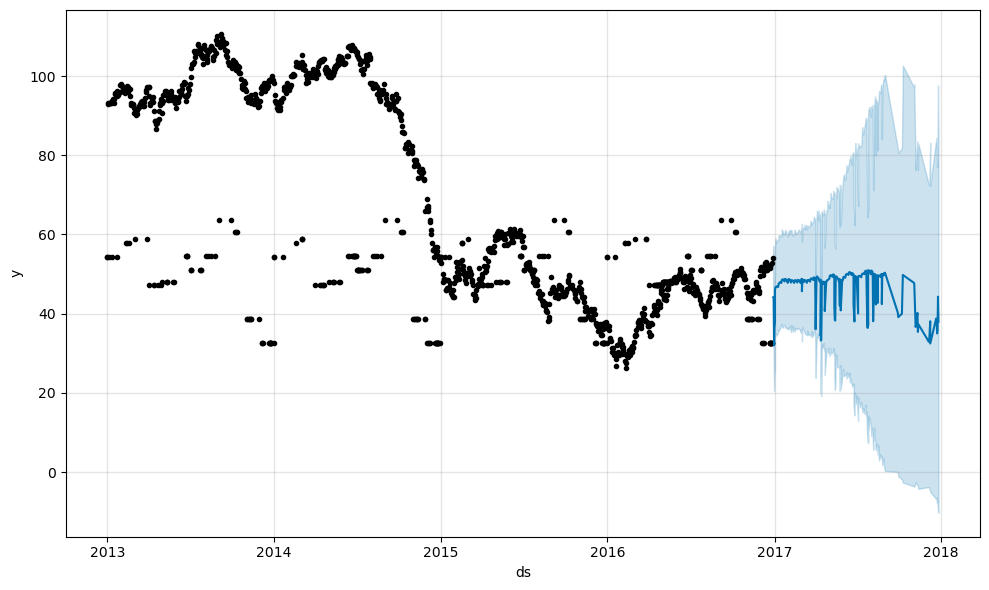

In [157]:
pd.set_option('display.max_rows', 500)

forecast = model.predict(test_x)
test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']

plot_measure = model.plot(forecast)
print(forecast[['ds', 'yhat', 'true', 'yhat_lower', 'yhat_upper']])

In [158]:
mape = mean_absolute_percentage_error(forecast['true'], forecast['yhat'])
mae = mean_absolute_error(forecast['true'], forecast['yhat'])

print('MAPE is ', round(mape, 3))
print('MAE is ', round(mae,3))
test_y = test_y.reset_index()
forecast['true'] = test_y['dcoilwtico']



MAPE is  0.093
MAE is  4.628


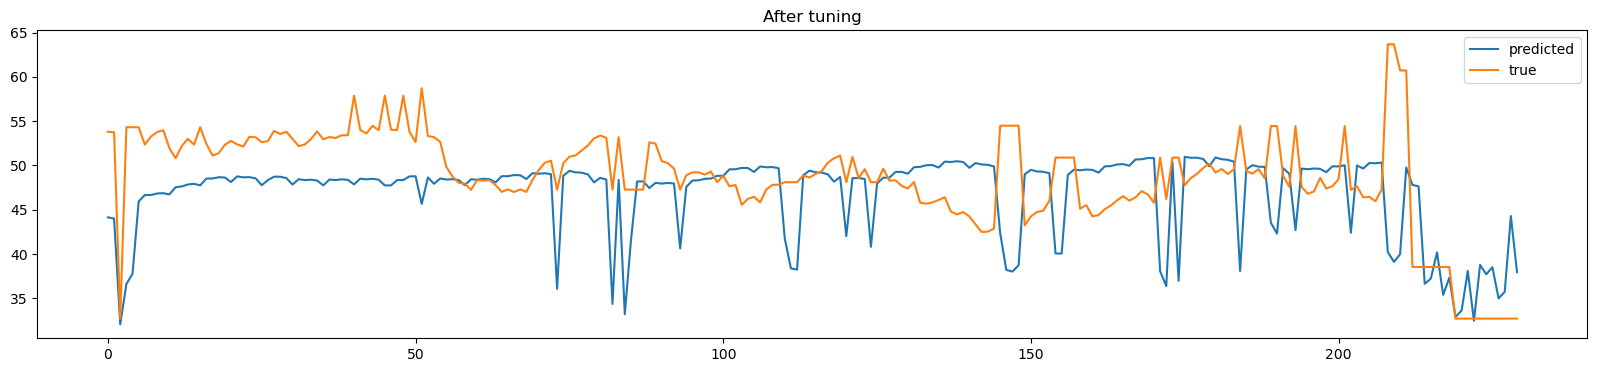

In [159]:
plt.figure(figsize=(20,4))
plt.plot(forecast['yhat'], label='predicted')
plt.plot(forecast['true'], label='true')
plt.legend()
plt.title('After tuning')
plt.show()

In [224]:
test_y = pd.DataFrame(test_y)
train_copy = train_copy.set_index('ds')
forecast_copy = forecast.copy()
forecast_copy = forecast_copy.set_index('ds')

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Additional,Additional_lower,Additional_upper,Ambato,Ambato_lower,...,year_lower,year_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,true
ds,,,,,,,,,,,,,,,,,,,,,
2016-12-29,5.702299,32.731066,57.127746,5.702299,5.702299,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.196087,2.196087,-0.630563,-0.630563,-0.630563,0.0,0.0,0.0,44.136815,53.80
2016-12-30,5.699850,30.985801,54.981204,5.699850,5.699850,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.196087,2.196087,-0.635109,-0.635109,-0.635109,0.0,0.0,0.0,44.007590,53.75
2016-12-31,5.697402,20.490661,44.115604,5.697402,5.697402,0.195217,0.195217,0.195217,0.000000,0.000000,...,2.196087,2.196087,-0.634900,-0.634900,-0.634900,0.0,0.0,0.0,32.058800,32.70
2017-01-01,5.694953,24.861095,48.161454,5.694953,5.694953,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.630004,-0.630004,-0.630004,0.0,0.0,0.0,36.600654,54.32
2017-01-02,5.692504,25.849734,50.085064,5.692504,5.692504,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.620578,-0.620578,-0.620578,0.0,0.0,0.0,37.771882,54.32
2017-01-02,5.692504,34.002907,56.733871,5.691056,5.692504,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.620578,-0.620578,-0.620578,0.0,0.0,0.0,45.940756,54.32
2017-01-03,5.690056,34.768048,58.986358,5.685670,5.691067,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.606865,-0.606865,-0.606865,0.0,0.0,0.0,46.659787,52.36
2017-01-04,5.687607,34.851328,57.697130,5.678374,5.691496,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.589187,-0.589187,-0.589187,0.0,0.0,0.0,46.662877,53.26
2017-01-05,5.685158,34.754182,58.599049,5.671307,5.691323,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.691271,3.691271,-0.567937,-0.567937,-0.567937,0.0,0.0,0.0,46.833982,53.77


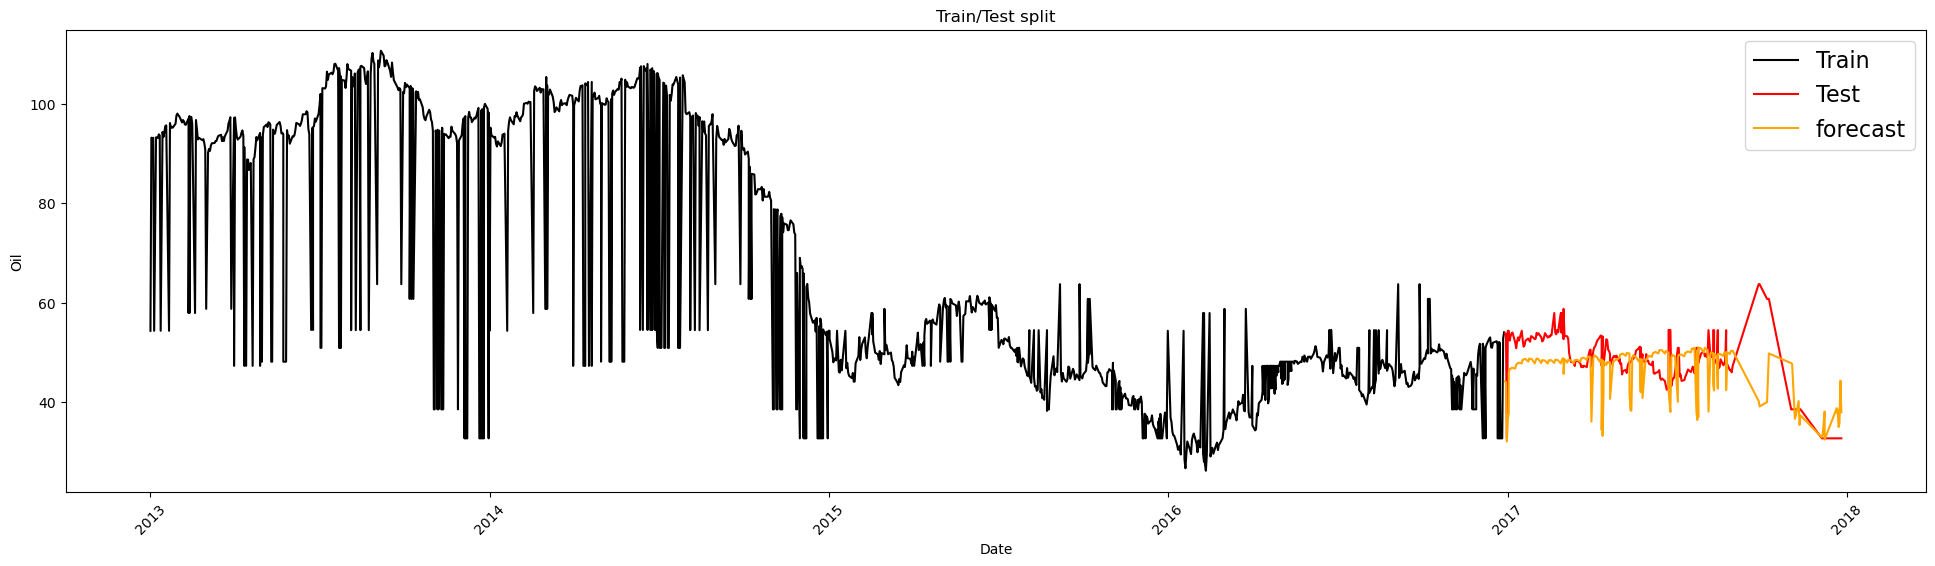

In [232]:
plt.figure(figsize=(24,6))
plt.plot(train_copy['y'], color = "black", label='Train')
plt.plot(test_y['dcoilwtico'], color = "red", label='Test')
plt.plot(forecast_copy['yhat'], color = "orange", label='forecast')
plt.ylabel('Oil')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split")
plt.legend(prop={'size': 16})
plt.show()